## 금주 목표
### 이번 시즌 팀 순위 시각화

In [74]:
import natsort as natsort
import pandas as pd
import os
import natsort
from datetime import date, datetime
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus']= False
from IPython.core.display_functions import display


In [75]:
team_list = ["LG", "SSG", "KT", "NC", "두산", "키움", "한화", "KIA", "삼성", "롯데"]
color_list=["#DB1916", "#fff000", "#000000", "#C79F79", "#000066", "#660066", "#FF7F00", "#ff0000","#0000ff", "#330066"]

In [76]:
for month in range(4, 11):
    url = "https://sports.news.naver.com/kbaseball/schedule/index?&month={}&year=2022&teamCode=".format(month)
    df = pd.read_html(url)
    for i in range(1, len(df)-1): #제일 위에 column 목차가 df단위로 떨어져서 삭제하는걸로 함, 그리고 마지막 df는 <맨위로>키 정보가 있는 테이블이라 범위에 넣지 않음.
        if df[i][2][0] == "프로야구 경기가 없습니다.":
            continue
        remain= df[i].loc[:, [0, 1, 2, 4, 5]]
        remain.rename(columns={0:"일자", 1:"시각", 2:"경기결과", 4:"중계사", 5:"구장"} , inplace=True)
        text = remain["일자"][0].split()[0]
        remain["일자"] = text
        remain.to_csv("./date/"+text+'.csv', header=True, encoding='UTF-8', index=False)
    print(month, "완료")

4 완료
5 완료
6 완료
7 완료
8 완료
9 완료
10 완료


## DataFrame 에서 얻어낸 것
1. 네이버는 https 프로토콜을 사용하므로 ssl때문에 certification 관련 추가 작업이 필요했음
1-1. 따라서 terminal에 `pip install --upgrade certifi`를 추가적으로 작성함
1-2. 그리고 Application > python 3.10 > install certifi 진행
2. 네이버의 경우, 일정별로 깔끔하게 떨어져서 나옴
3. 다만, 데이터프레임의 개수가 많이 나타남

## 게임차 계산방법
```
팀 게임 승점 = (전체경기수 - 진행된 경기수)*0.5 + 승리 수 + 무승부*0.5
1위 승점 - 현재 팀 승점
```
- 패배를 왜 뺐나 했는데, 정말로 게임차 계산할 때 패배는 들어가지 않음.
- 실제로도 승리랑 무승부 가지고 판단함

In [77]:
init_data = [0,0,0,0,0,0]
KBO_team = pd.DataFrame(columns=["경기수", "승리", "무승부", "패배", "득점", "실점"], index=team_list)
for team in team_list:
    KBO_team.loc[team] = init_data

KBO_team

,경기수,승리,무승부,패배,득점,실점
LG,0,0,0,0,0,0
SSG,0,0,0,0,0,0
KT,0,0,0,0,0,0
NC,0,0,0,0,0,0
두산,0,0,0,0,0,0
키움,0,0,0,0,0,0
한화,0,0,0,0,0,0
KIA,0,0,0,0,0,0
삼성,0,0,0,0,0,0
롯데,0,0,0,0,0,0


In [78]:
order_list = os.listdir("./date")
sorted_list = natsort.natsorted(order_list)

In [1]:
for file in sorted_list:
    data = pd.read_csv("./date/" + file)
    for i in data.index:
        line = data.loc[i, :]

        if len(line[2].split(":")) == 1:
            continue

        away, home = line[2].split(":")
        home = home.split()
        away = away.split()
        h_score, h_team = home
        a_team, a_score = away
        h_score = int(h_score)
        a_score = int(a_score)

        if h_team == "나눔" or a_team == "나눔":
            continue #올스타전 제외

        KBO_team.loc[h_team, ["득점"]] += h_score
        KBO_team.loc[h_team, ["실점"]] += a_score
        KBO_team.loc[a_team, ["득점"]] += a_score
        KBO_team.loc[a_team, ["실점"]] += h_score

        #리팩토링은 항상 모두 완료하고나서 할 것
        if h_score > a_score: #홈팀 승리
            KBO_team.loc[h_team, ["승리"]] +=1
            KBO_team.loc[a_team, ["패배"]] +=1
        elif h_score < a_score:
            KBO_team.loc[a_team, ["승리"]] +=1
            KBO_team.loc[h_team, ["패배"]] +=1
        else:
            KBO_team.loc[h_team, ["무승부"]] +=1
            KBO_team.loc[a_team, ["무승부"]] +=1

        #경기수 구하기
        KBO_team["경기수"] = KBO_team["승리"] + KBO_team["패배"] + KBO_team["무승부"]

        #게임차 구하기
        KBO_team["승점"] = (144-KBO_team["경기수"])*0.5 + KBO_team["승리"] + KBO_team["무승부"]*0.5
        KBO_team.sort_values(by="승점", inplace=True, ascending=False)
        top = KBO_team["승점"][0]
        KBO_team["게임차"] = top - KBO_team["승점"]
        KBO_team.sort_values(by="승점", ascending=False, inplace=True)

        #KBO_team["순위"] = [1,2,3,4,5,6,7,8,9,10] #순위 이렇게 책정하는거 아님. 승점가지고 비교하면 될 거 같

        KBO_team["순위"] = KBO_team["승점"].rank(method = "min", ascending=False)
        KBO_team["순위"] = KBO_team["순위"].astype('int')

        KBO_team.to_csv("./date_rank/"+file, header=True, encoding="UTF-8", index=True)
#원인찾았다. 이거 숫자가 문자열로 되어있어서 그랬음

NameError: name 'sorted_list' is not defined

In [2]:
KBO_team

NameError: name 'KBO_team' is not defined

## 시각화 진행할 것

In [81]:
rank_list = os.listdir("./date_rank")
sorted_rank = natsort.natsorted(rank_list)

#sorted_rank

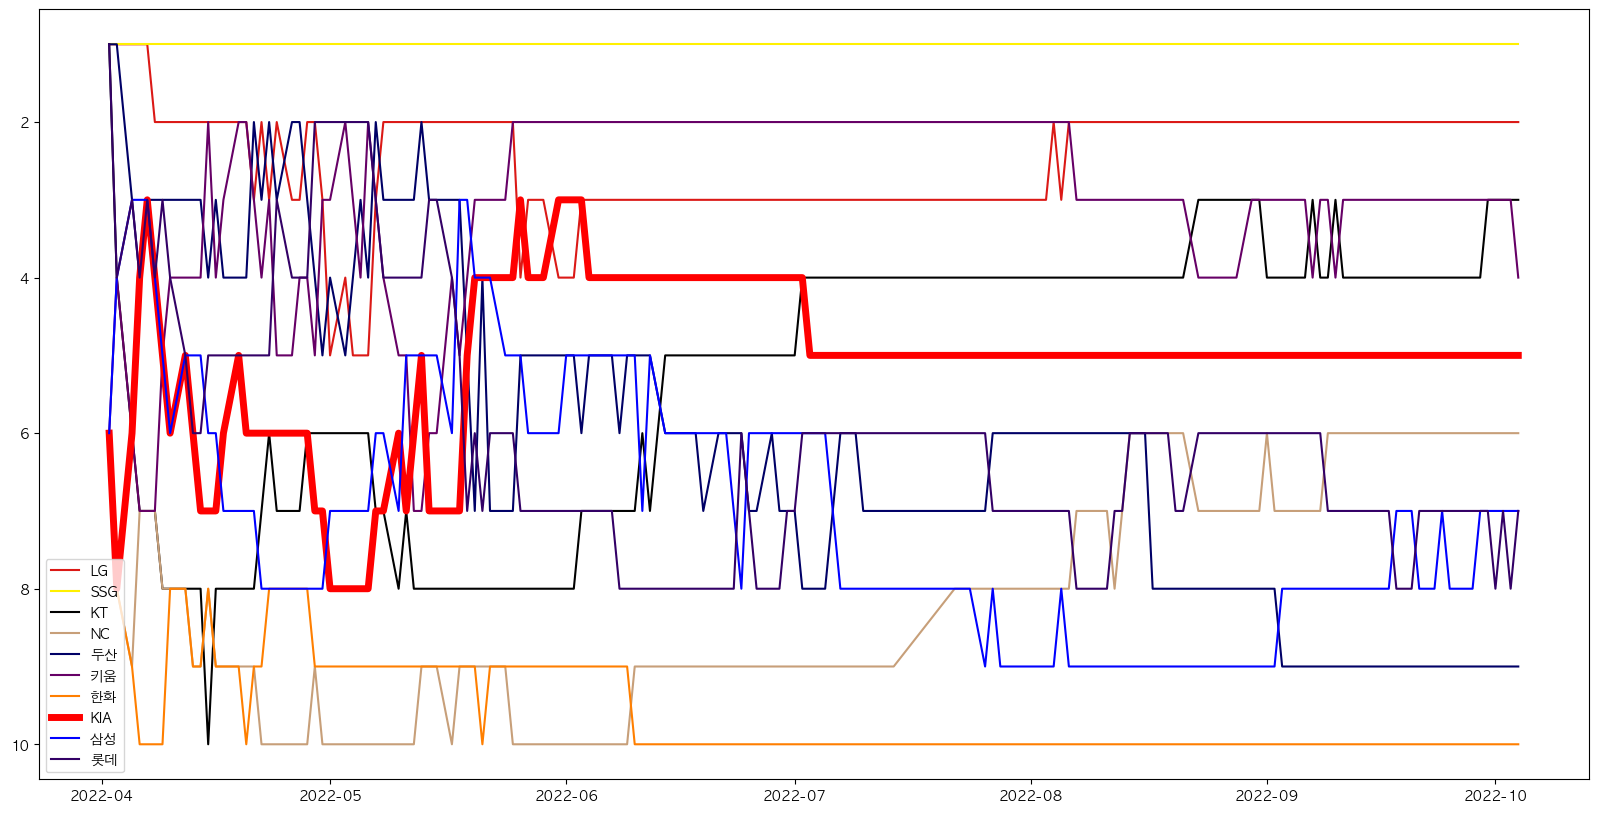

In [96]:
for team, color in zip(team_list, color_list):
    df_result = pd.DataFrame(columns=["경기수", "승리", "무승부", "패배","득점","실점","승점", "게임차", "순위", "일자"])

    for file in sorted_rank:
        if file == ".DS_Store" or file == "7.16.csv":
            continue
        date = datetime.strptime("2022."+file.replace(".csv", ''), '%Y.%m.%d')
        rank_df = pd.read_csv("./date_rank/"+file, index_col=0)
        rank_df["일자"] = date

        rank_list = list(rank_df.loc[team, :])
        df_result.loc[len(df_result)] = rank_list
    plt.gcf().set_size_inches(20, 10)
    if team == "KIA":
        plt.plot(df_result["일자"], df_result["순위"], label=team, color=color, linewidth=5.0)
        continue
    plt.plot(df_result["일자"], df_result["순위"], label=team, color=color)
plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.show()

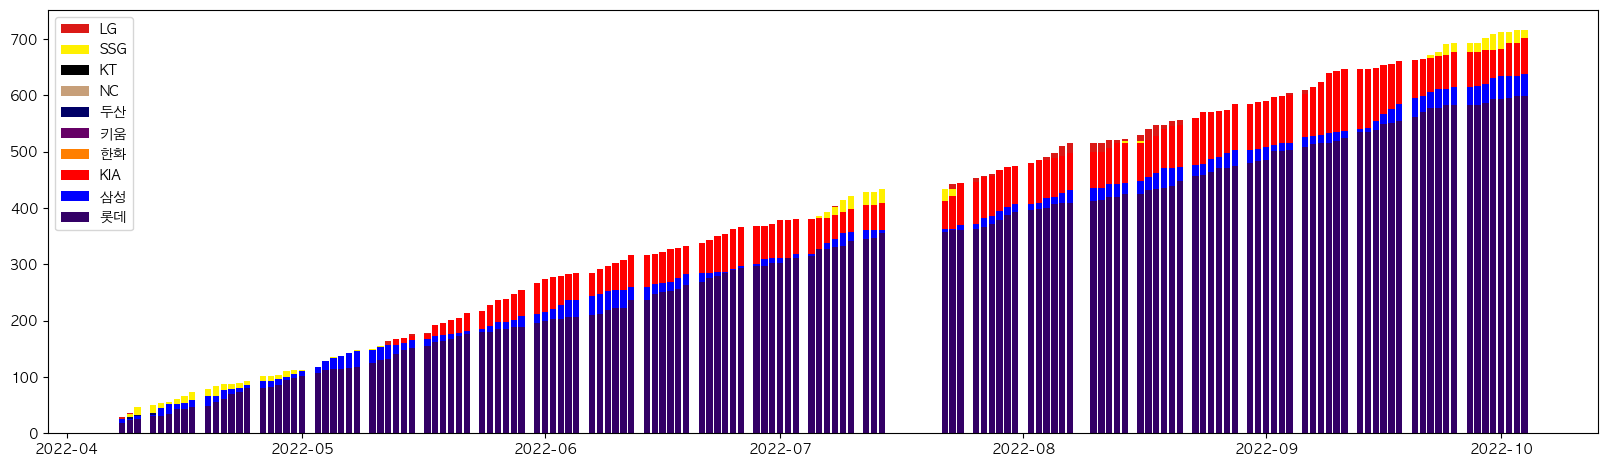

In [83]:
for team, color in zip(team_list, color_list):
    df_result = pd.DataFrame(columns=["경기수", "승리", "무승부", "패배","득점","실점","승점", "게임차", "순위", "일자"])

    for file in sorted_rank[5:]:
        if file == ".DS_Store" or file=="7.16.csv":
            continue
        date = datetime.strptime("2022."+file.replace(".csv", ''), '%Y.%m.%d')
        rank_df = pd.read_csv("./date_rank/"+file, index_col=0)
        rank_df["일자"] = date

        rank_list = list(rank_df.loc[team, :])
        df_result.loc[len(df_result)] = rank_list
    plt.gcf().set_size_inches(20, 5.5)
    plt.gca().invert_yaxis()
    plt.bar(df_result["일자"], df_result["득점"],label=team, color=color)
plt.legend(loc='best')
plt.show()

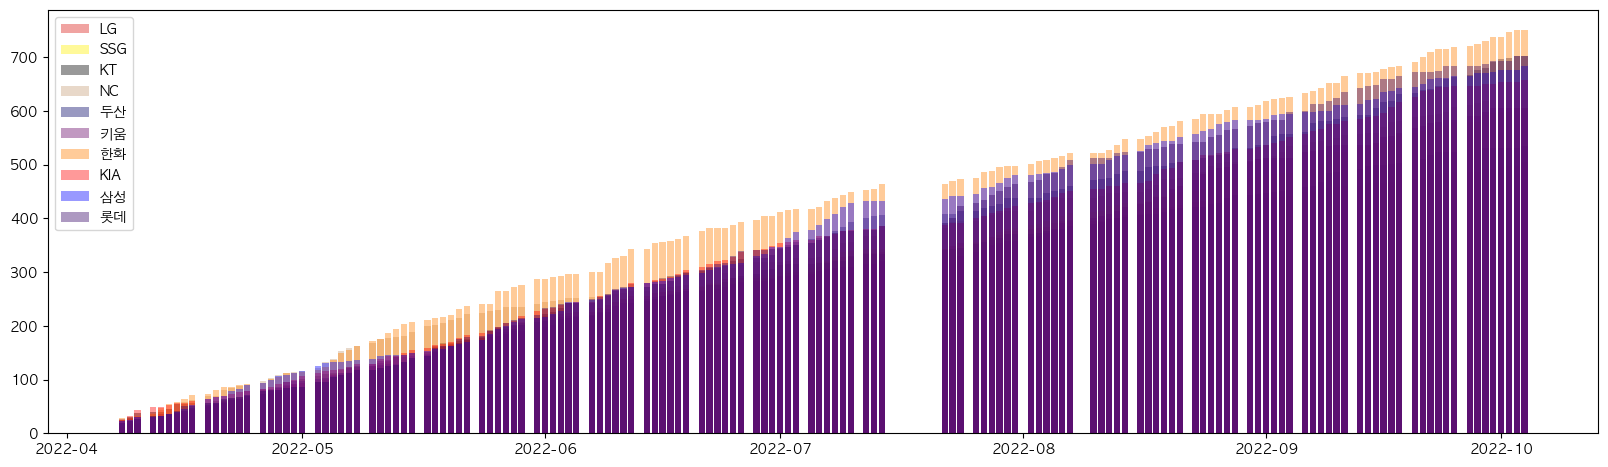

In [84]:
for team, color in zip(team_list, color_list):
    df_result = pd.DataFrame(columns=["경기수", "승리", "무승부", "패배","득점","실점","승점", "게임차", "순위", "일자"])

    for file in sorted_rank[5:]:
        if file == ".DS_Store" or file=="7.16.csv":
            continue
        date = datetime.strptime("2022."+file.replace(".csv", ''), '%Y.%m.%d')
        rank_df = pd.read_csv("./date_rank/"+file, index_col=0)
        rank_df["일자"] = date

        rank_list = list(rank_df.loc[team, :])
        df_result.loc[len(df_result)] = rank_list
    plt.gcf().set_size_inches(20, 5.5)
    plt.bar(df_result["일자"], df_result["실점"],label=team, color=color, alpha=0.4)
plt.legend(loc='best')
plt.show()

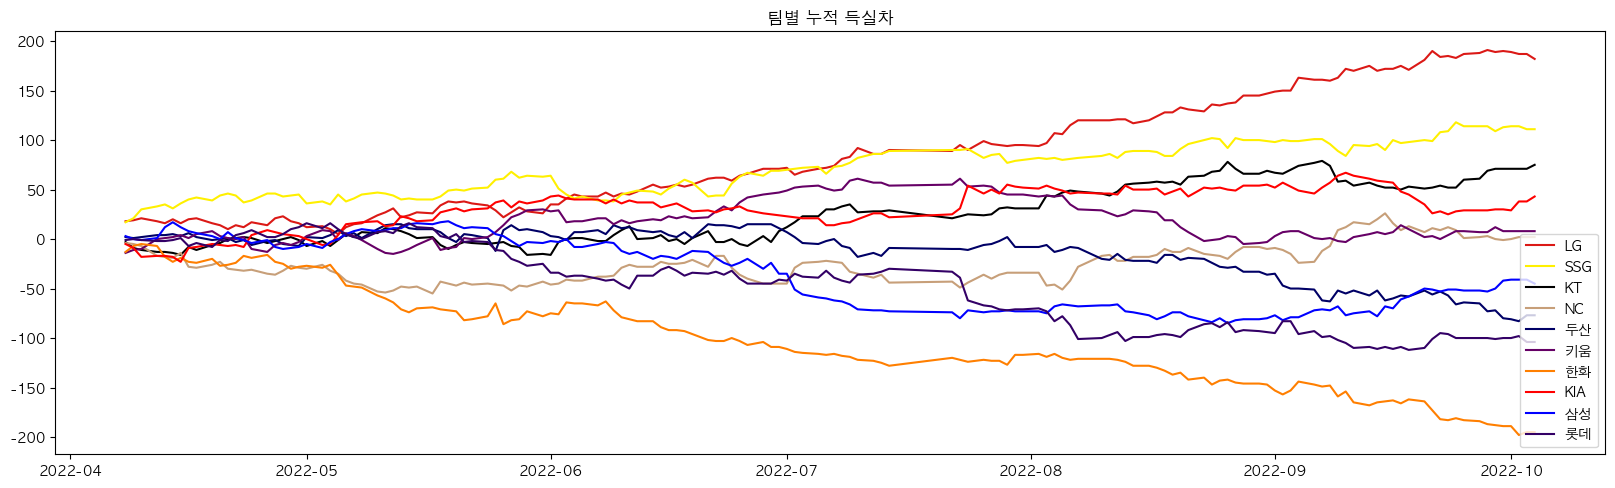

In [85]:
for team, color in zip(team_list, color_list):
    df_result = pd.DataFrame(columns=["경기수", "승리", "무승부", "패배","득점","실점","승점", "게임차", "순위", "일자", "득실차"])

    for file in sorted_rank[5:]:
        if file == ".DS_Store" or file=="7.16.csv":
            continue
        date = datetime.strptime("2022."+file.replace(".csv", ''), '%Y.%m.%d')
        rank_df = pd.read_csv("./date_rank/"+file, index_col=0)
        rank_df["일자"] = date
        rank_df["득실차"] = rank_df["득점"] - rank_df["실점"]

        rank_list = list(rank_df.loc[team, :])
        df_result.loc[len(df_result)] = rank_list
    plt.gcf().set_size_inches(20, 5.5)
    plt.plot(df_result["일자"], df_result["득실차"],label=team, color=color)
plt.title("팀별 누적 득실차")
plt.legend(loc='best')
plt.show()

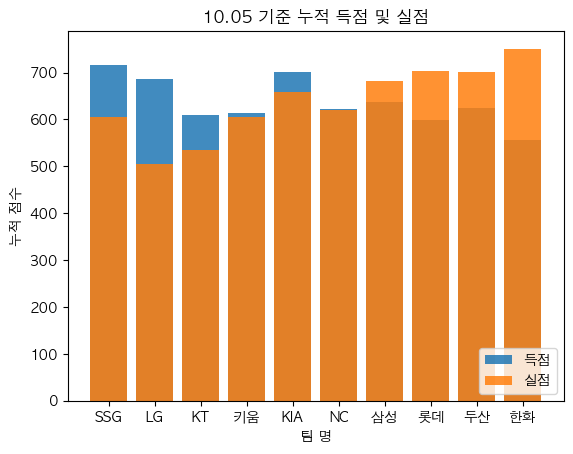

In [117]:
KBO_team["득실차"] = KBO_team["득점"] - KBO_team["실점"]
kbo = pd.DataFrame(KBO_team, columns=["득점", "실점", "득실차", "게임차"])

plt.title("10.05 기준 누적 득점 및 실점")
plt.bar(kbo.index, kbo["득점"], label="득점", alpha=0.85)
plt.bar(kbo.index, kbo["실점"], label="실점", alpha=0.85)
plt.legend(loc='lower right')
plt.xlabel("팀 명")
plt.ylabel("누적 점수")
plt.show()

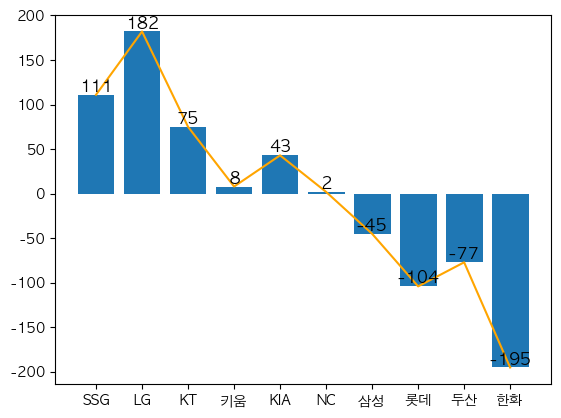

In [121]:
bar = plt.bar(kbo.index, kbo["득실차"], label="득실차")
plot = plt.plot(kbo.index, kbo["득실차"], label="득실차", color="orange")

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, "%d"%height, ha="center", va="bottom", size=12)

plt.show()